In [1]:
import os
import datetime as dt

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re

sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
ny_listings = pd.read_csv("cities/nyc/listings_nyc.csv", low_memory=False)

FileNotFoundError: [Errno 2] No such file or directory: 'cities/nyc/listings_nyc.csv'

In [86]:
ny_nbh = pd.read_csv("cities/nyc/neighbourhoods_nyc.csv", low_memory=False)

In [87]:
ny_cal = pd.read_csv("cities/NYC/calendar_nyc.csv.gz", compression="gzip", header=0, sep=",")

### EDA on Airbnb calendar data for NYC

In [88]:
ny_cal.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,2595,2022-06-04,f,$225.00,$225.00,30.0,1125.0
1,2595,2022-06-05,f,$225.00,$225.00,30.0,1125.0
2,2595,2022-06-06,f,$225.00,$225.00,30.0,1125.0
3,2595,2022-06-07,f,$225.00,$225.00,30.0,1125.0
4,2595,2022-06-08,f,$225.00,$225.00,30.0,1125.0


In [89]:
ny_cal.shape

(13649178, 7)

In [90]:
ny_cal.columns

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

In [91]:
ny_cal.dtypes

listing_id          int64
date               object
available          object
price              object
adjusted_price     object
minimum_nights    float64
maximum_nights    float64
dtype: object

In [92]:
ny_cal.describe().drop("listing_id", axis=1)

,minimum_nights,maximum_nights
count,1.364882e+07,1.364882e+07
mean,2.698060e+01,2.322437e+06
std,7.819838e+01,7.055527e+07
min,1.000000e+00,1.000000e+00
25%,2.000000e+00,3.650000e+02
50%,3.000000e+01,1.125000e+03
75%,3.000000e+01,1.125000e+03
max,1.250000e+03,2.147484e+09


In [93]:
print("Unique listings in NYC:", len(ny_cal.listing_id.unique()))

Unique listings in NYC: 37395


#### Clean price column and summarize mean

In [94]:
# remove na in price column
ny_cal_cut = ny_cal[ny_cal.price.notna()]

# clean price column
new_price = [ p.replace("$", "").replace(",", "") for p in ny_cal_cut.price ]
ny_cal_cut.price = new_price
ny_cal_cut.price = round(ny_cal_cut.price.astype("float"), 2)

ny_cal_cut.price.describe().apply("{0:.4f}".format)

count    13649007.0000
mean          195.1919
std           375.8150
min             0.0000
25%            78.0000
50%           125.0000
75%           204.0000
max         48800.0000
Name: price, dtype: object

In [95]:
# summarize price by mean price by listing
ny_mean_price = ny_cal_cut.groupby("listing_id")["price"].mean().reset_index(name="mean")

ny_mean_price

,listing_id,mean
0,2595,213.495890
1,5121,60.000000
2,5136,275.000000
3,5178,68.147945
4,5203,78.635616
...,...,...
37390,640612171111039003,180.000000
37391,640629990855220048,620.000000
37392,640658348674867448,92.589041
37393,641072234133563797,528.616438


#### Cast date column to datetime type & visualize prices by day

In [96]:
# cast to date
ny_cal_cut['date'] = pd.to_datetime(ny_cal_cut['date'])

In [97]:
# summarize mean price
ny_price_day = ny_cal_cut.groupby("date")["price"].mean().reset_index(name="mean_price")

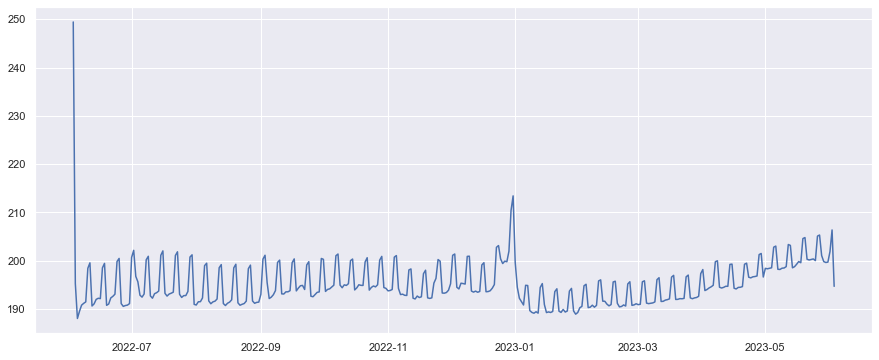

In [98]:
# visualize mean price by day
plt.figure(figsize=(15,6))
plt.plot(ny_price_day.date, ny_price_day.mean_price)
plt.show()

#### Model Selection

In [99]:
from sklearn.model_selection import train_test_split

def split_data(data):
    train, test_and_validate = train_test_split(data, test_size=0.2, random_state=9, stratify=data['date'])
    test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=9, stratify=test_and_validate['date'])
    return train, validate, test

In [100]:
# x value will be prices
data = ny_cal_cut[["date", "price"]]

data['date'] = data['date'].map(dt.datetime.toordinal)

train, validate, test = split_data(data)
print("Train data size: ", train['date'].size)
print("Test data size: ", test['date'].size)
print("Validate data size: ", validate['date'].size)

Train data size:  10919205
Test data size:  1364901
Validate data size:  1364901


In [101]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

In [102]:
X_train = train["date"].values.reshape(-1, 1)
y_train = train["price"].values.reshape(-1, 1)

reg.fit(X_train, y_train)

LinearRegression()

In [103]:
X_test = test["date"].values.reshape(-1, 1)
y_test = test["price"].values.reshape(-1, 1)

preds = reg.predict(X_test)

In [104]:
reg.score(y_test, preds)

-49097103.2385889

#### Arima/Rolling Average

In [105]:
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime  
from datetime import timedelta  

def arma_log_ret(ser, p, q, num_forecasts):
    df = ser.reset_index()
    start = df['date'].iloc[-1] + timedelta(days=1)  

    model = ARIMA(ser,order=(p,0,q)).fit()
    forecasts = model.predict(start = start, end = start + timedelta(days=num_forecasts-1))
    
    return forecasts


def calc_rolling_stats(ser, wd_size=7):
    rolling_mean = ser.rolling(wd_size, min_periods=1).mean().to_numpy()
    
    if wd_size == 1:
        rolling_std = ser.rolling(wd_size).std(ddof=0).to_numpy()
    else:
        rolling_std = ser.rolling(wd_size, min_periods=1).std(ddof=0).to_numpy()
    
    return rolling_mean, rolling_std
    
def calc_log_ret(ser):
    log_ret = np.log(ser) - np.log(ser.shift(1))
    
    log_ret.dropna(inplace=True)
    
    return log_ret

In [106]:
# summarize price by mean price by day
ny_mean_dailyprice = ny_cal_cut.groupby("date")["price"].mean().reset_index(name="mean_price")

ny_mean_dailyprice.mean_price = round(ny_mean_dailyprice.mean_price, 2)

In [107]:
rolling_mean, rolling_std = calc_rolling_stats(ny_mean_dailyprice, wd_size=7)

In [108]:
rolling_mean.shape

(366, 1)

In [109]:
rolling_std.shape

(366, 1)

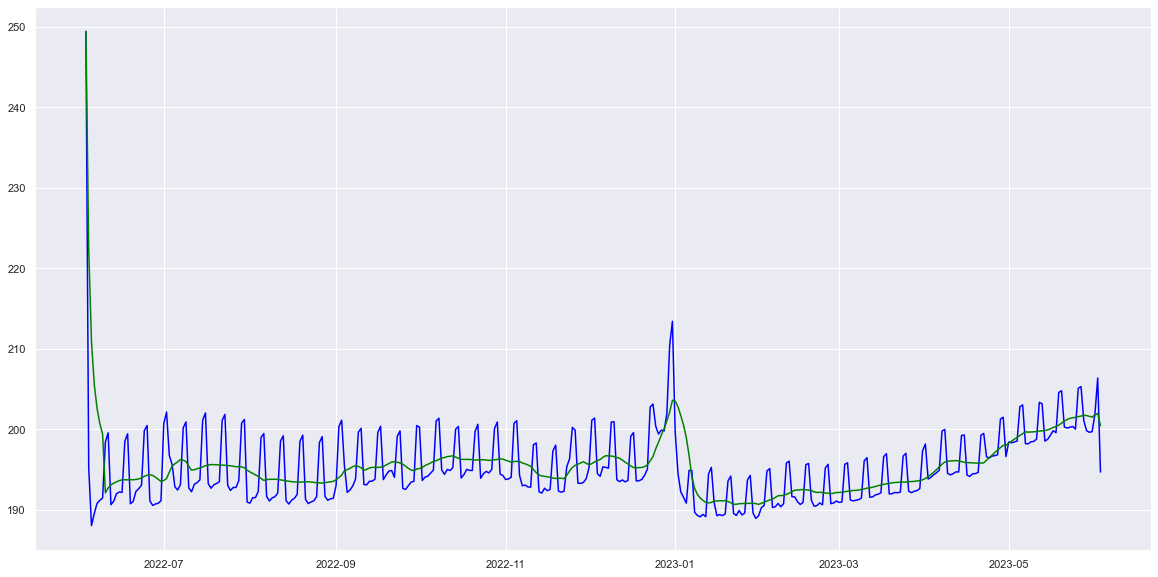

In [110]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(ny_mean_dailyprice.date, ny_mean_dailyprice.mean_price, color='blue')
ax.plot(ny_mean_dailyprice.date, pd.Series(rolling_mean.reshape(366,)), color='green')
# ax.plot(ny_mean_dailyprice.date, pd.Series(rolling_std.reshape(366,)), color='orange')

plt.show()

In [111]:
ny_mean_dailyprice = ny_cal_cut.groupby("date")["price"].mean().reset_index(name="mean_price")

ny_mean_dailyprice.mean_price = round(ny_mean_dailyprice.mean_price, 2)

ser = ny_mean_dailyprice
p=1
q=1
num_forecasts=365

df = ser.reset_index()
# start = df['date'].iloc[-1] + timedelta(days=1) 

# ser.index = pd.to_datetime(ser.date)
# ser = ser.resample("M").last()

start = df['date'].iloc[-1] + timedelta(days=1) 

df = ser.set_index("date")

end = start + timedelta(days=364)
model = ARIMA(df,order=(p,0,q), freq='D').fit()

forecasts = model.predict(start = start, end = end)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


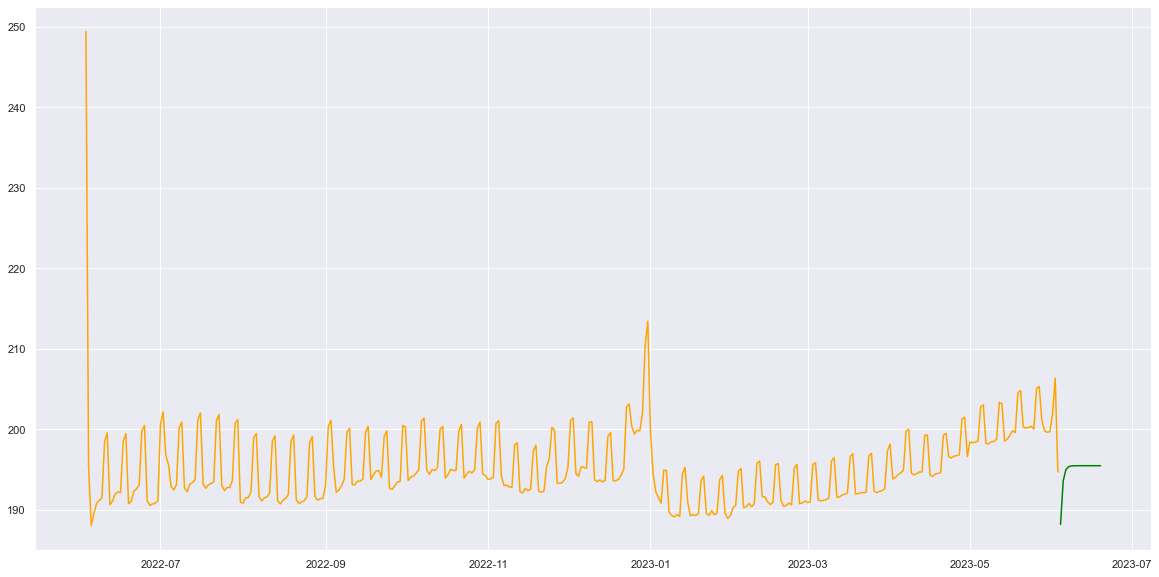

In [112]:
forecast_df = forecasts.reset_index()
forecast_df = forecast_df.rename(columns={'index':'date'})
forecast_df = forecast_df.loc[:15, :]

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(ny_mean_dailyprice.date, ny_mean_dailyprice.mean_price, label="Original", color='orange')
ax.plot(forecast_df.date, forecast_df.predicted_mean, label="Forecasted", color='green')

plt.show()